##### Importing libraries and framework

In [65]:
# Import the necessary libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import pandas as pd

#### Prepare the data  (able to reuse the code from linear_regression.ipynb)

In [66]:
# Load the data from the CSV file into a DataFrame
data = pd.read_csv('datasets/listings_preprocessed.csv')

# Separate the input features (X) and target variable (y)
X = data.drop('price', axis=1)
y = data['price']

# Filter out non-numeric columns
numeric_columns = X.select_dtypes(include=['number']).columns
X_numeric = X[numeric_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# One-hot encode categorical features
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align the columns of the training and testing sets
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Fill missing values in the training set with the mean of each column
X_train.fillna(X_train.mean(), inplace=True)

# Fill missing values in the test set with the mean of the corresponding columns in the training set
X_test.fillna(X_train.mean(), inplace=True)

# Fill remaining NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

#### Filter and extract only top 7 variables to be used to predict the price (able to reuse the code from linear_regression.ipynb)

In [67]:
# Calculate the correlation matrix between features and the target variable
corr_matrix = X_train.corrwith(y_train)

# Select the top 20 variables with the highest positive correlation values
top_7_correlated = corr_matrix[corr_matrix > 0].sort_values(ascending=False)[:7]

# Print the top 20 variables
print("Top 20 positively correlated variables:\n", top_7_correlated)

# Filter the original training and testing sets to include only the top 20 correlated variables
X_train_selected = X_train[top_7_correlated.index]
X_test_selected = X_test[top_7_correlated.index]

Top 20 positively correlated variables:
 bedrooms                                       0.425693
calculated_host_listings_count_entire_homes    0.410485
host_listings_count                            0.347692
calculated_host_listings_count                 0.323658
host_total_listings_count                      0.316270
host_id                                        0.305003
property_type_Entire rental unit               0.288468
dtype: float64


#### Create the model and predict the data

In [68]:
# Create a decision tree regression model
model = DecisionTreeRegressor(random_state=42)

# Train the model using the training data with the selected features
model.fit(X_train_selected, y_train)

# Predict the prices for the test set
y_pred = model.predict(X_test_selected)

#### Display the performance metrics

In [69]:
# Calculate the mean squared error and R^2 score for the predictions
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("Performance metrics")
print("Mean squared error:", mse)
print("R^2 score:", r2)

Performance metrics
Mean squared error: 7397.52744687687
R^2 score: 0.5512680921618336


#### Decision tree models do not have coefficients like linear regression models. Decision trees use a tree-like structure to make decisions based on feature values rather than using coefficients to represent the relationship between the features and the target variable.

#### However, I can obtain the feature importances from a decision tree model, which represent how important each feature is for making predictions. The higher the importance, the more the feature contributes to the model's decision-making process. Here's how you can obtain and print the feature importances:

In [70]:
# Pair feature names with their importances and sort in descending order
sorted_importances = sorted(zip(top_7_correlated.index, feature_importances), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
print("Feature importance")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

Feature importance
calculated_host_listings_count_entire_homes: 0.2766
host_id: 0.1657
bedrooms: 0.0553
calculated_host_listings_count: 0.0510
host_total_listings_count: 0.0273
host_listings_count: 0.0124
property_type_Entire rental unit: 0.0060


#### To visualize the performance of the decision tree model, you can create a scatter plot of the true prices (y_test) against the predicted prices (y_pred), similar to the linear regression model:

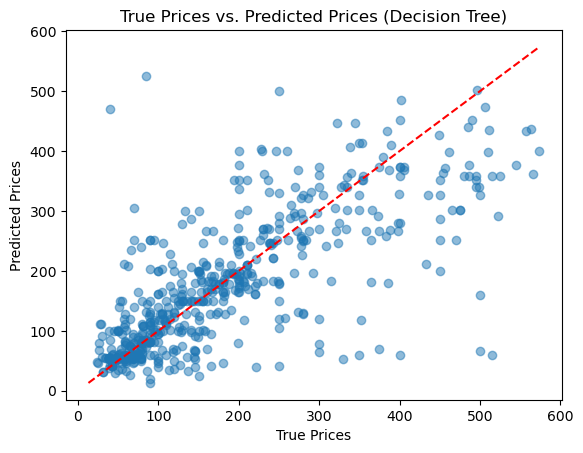

In [71]:
# Create a scatter plot of the true prices against the predicted prices
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('True Prices vs. Predicted Prices (Decision Tree)')

# Add a diagonal line to represent perfect predictions
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Show the plot
plt.show()

#### Plot the decision tree model

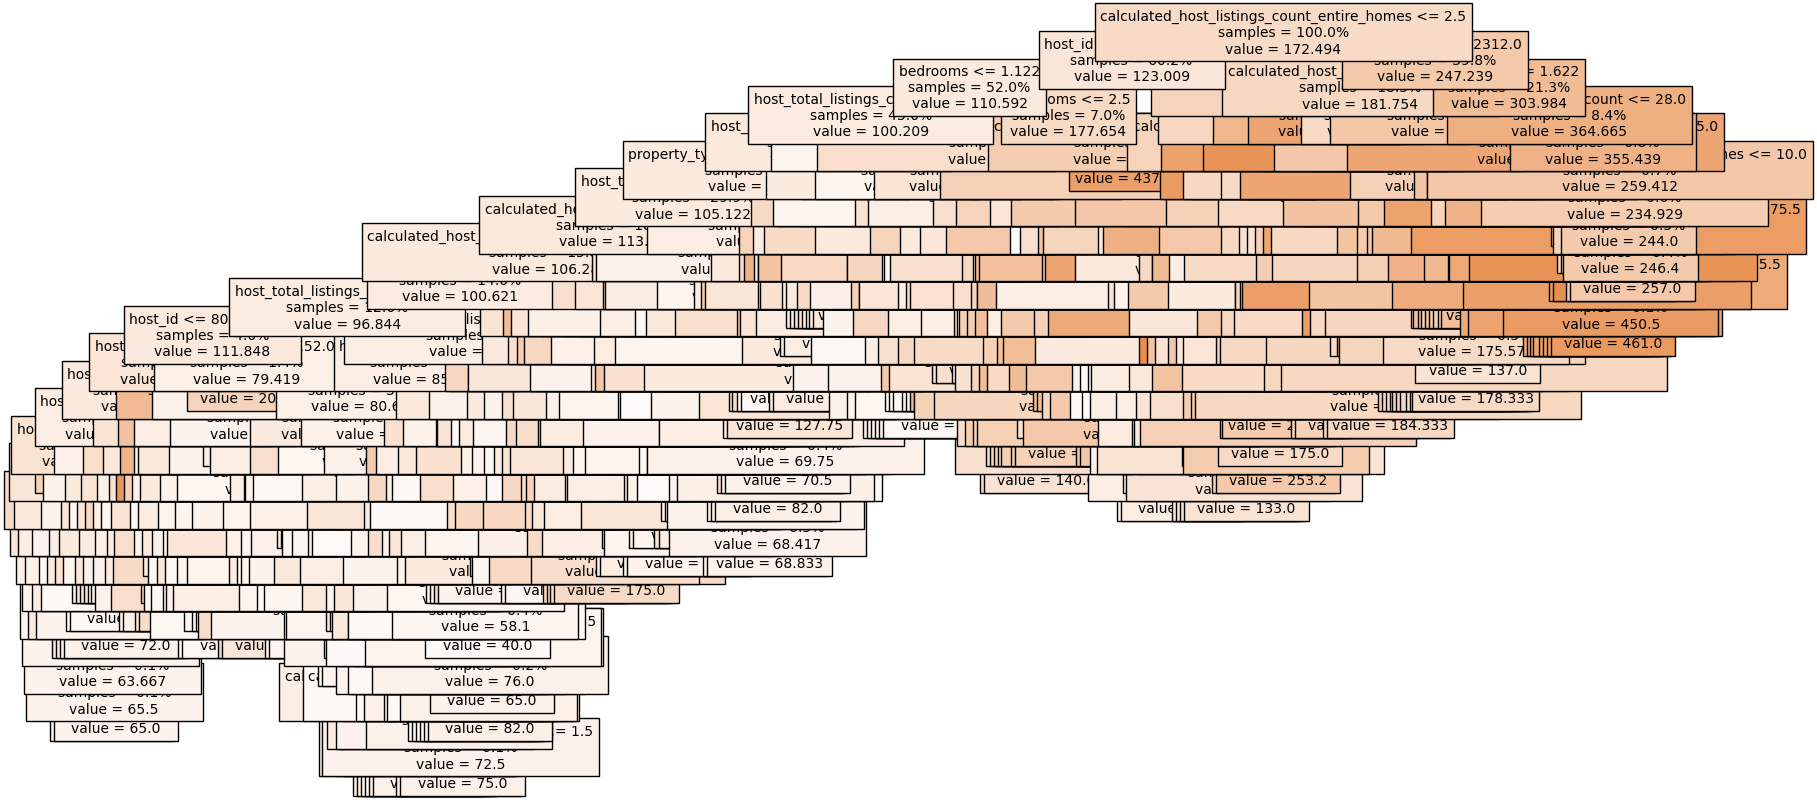

In [72]:
from sklearn.tree import plot_tree

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the decision tree
plot_tree(model, ax=ax, feature_names=top_7_correlated.index, filled=True, fontsize=10, impurity=False, proportion=True)

# Show the plot
plt.show()

#### As there are many variables to compare along, we have concluded that decision tree regression is not a suitable model.

#### Solution: We reduce the depth limit so that it is more presentable even though it might not be accurate

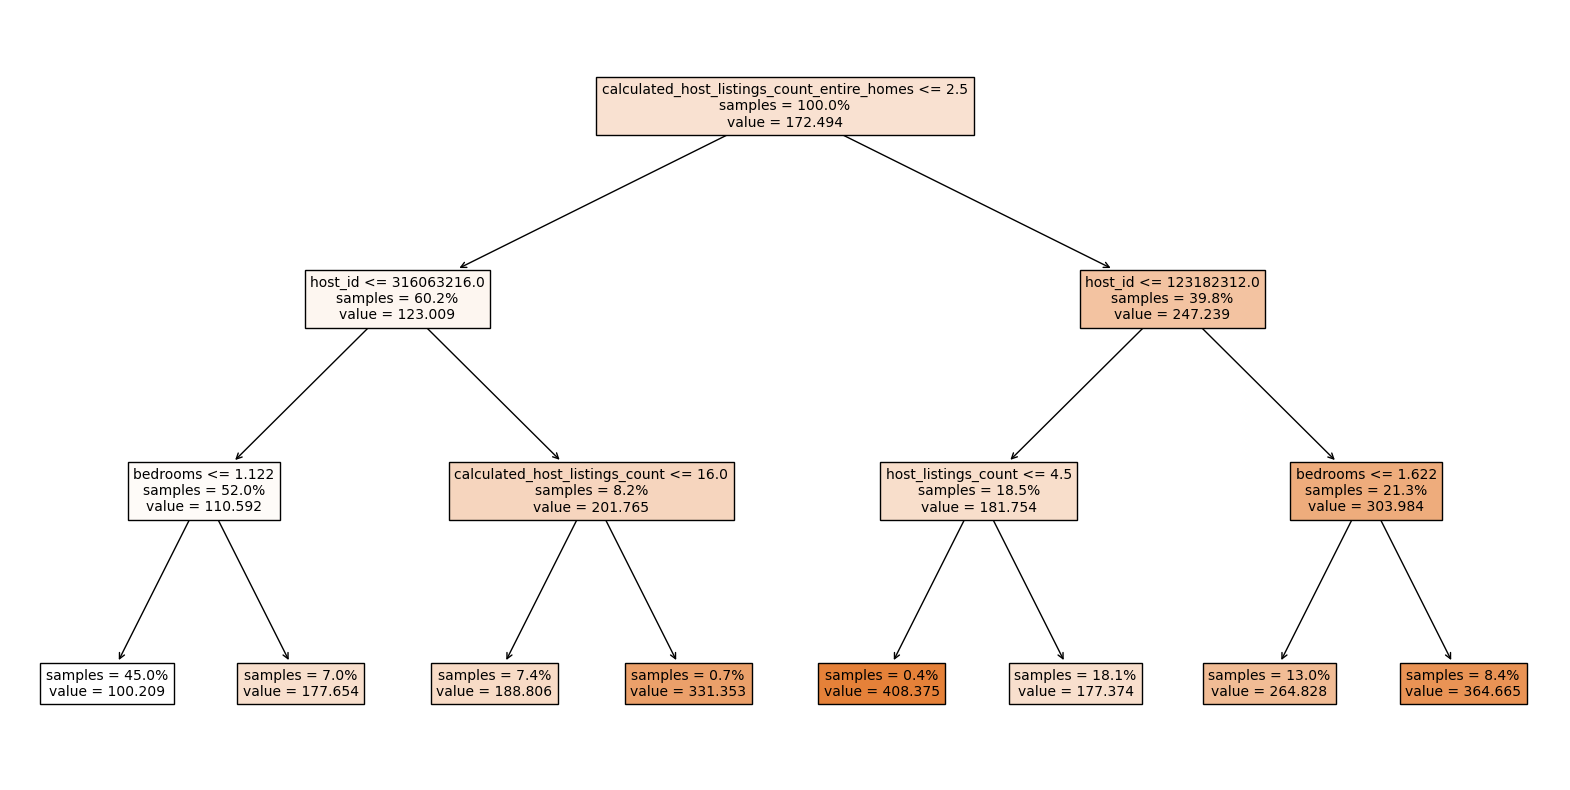

In [77]:
# Create a decision tree regression model with a limited depth
model = DecisionTreeRegressor(max_depth=3, random_state=42)

# Train the model using the training data with the selected features
model.fit(X_train_selected, y_train)

# Plotting the decision tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the decision tree
plot_tree(model, ax=ax, feature_names=top_7_correlated.index, filled=True, fontsize=10, impurity=False, proportion=True)

# Show the plot
plt.show()

#### Conclusion

#### Decision tree regression can handle both numerical and categorical data, so the variables with higher correlation coefficients as well as categorical variables can be used to build a decision tree regression model.